In athletics, there is still very little structured data on athlete performance, especially in middle-distance running. The goal of this project is to create a database of international middle-distance races with the most accurate splits possible.


First, we'll start by collecting the results books for the long-distance and middle-distance races from the World Athletics Championships. We'll then extract the data from these results books in PDF format to create a clean and accurate database. Finally, we'll use our new database to create a visualization.

# Install and Import packages

In [ ]:
# ---- INSTALL ----
!pip install PyPDF2
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install pycountry
# ---- IMPORT ----
import os
import PyPDF2
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import time
import tempfile
import warnings
import re
import spacy
from spacy.training import Example
import pycountry
import regex
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import lines
from matplotlib import patches
import numpy as np
from scipy.interpolate import make_interp_spline
# Remove the 'DeprecationWarning' messages
warnings.filterwarnings("ignore")

---
# Creation of a database from World Athletics Data

The main source of data we'll use to create our database is the [World Athletics results website](https://worldathletics.org/results). On this website, you can find a large list of competition with their results. In our case, we will focus only on the World [Indoor](https://worldathletics.org/results/world-athletics-indoor-championships) and [Outdoor](https://worldathletics.org/results/world-athletics-championships) championships, as they are the best combination in terms of high level performances and data quality.


---
## Retrieve the results books from the races

In athletics, most of the results of the events can be found in results books. Those results books are PDF files. Our first step in order to get World Athletics data will be to retrieve and store the results books from the races we want. In this section, we show how to retrieve the results books from the World Atheltics results website.

### Retrieve the links from the competitions
In order to get the results books, we need to get the links of all the competitions we want. To do that, we scrap separately the [World Athletics Indoor Championships](https://worldathletics.org/results/world-athletics-indoor-championships) and [World Athletics Championships](https://worldathletics.org/results/world-athletics-championships) results pages and retrieve the links of the competitions.

We use the `BeautifulSoup` library to scrap the pages, and we set the `verifiy` parameter to `False` to avoid the SSL verification.

When we have the page of the competition scraped, we search for the `<a>` tags which have:
- `'/results/world-athletics-championships'` **OR** `'/results/world-athletics-indoor-championships'` in their link.

**AND**

- No `'http'` in their link.

In [3]:
indoor_outdoor_url = {
    "outdoor":"https://worldathletics.org/results/world-athletics-championships",
    "indoor":"https://worldathletics.org/results/world-athletics-indoor-championships"
    }

# We set the 'verifiy' parameter to False to avoid the SSl verification
list_wc = {}
for comp_type, url in indoor_outdoor_url.items():
  list_wc[comp_type] = []
  response = requests.get(url, verify=False)
  if response.status_code == 200:
      soup = BeautifulSoup(response.content, "html.parser")

      # Find all links ('a' tags) on the page
      links = soup.find_all("a")

      # Browse links and look for those pointing to PDF files
      for link in links:
          link_href = link.get("href")
          # retrieve the year of the competition
          if (
              (('/results/world-athletics-championships' in str(link_href)) or
               ('/results/world-athletics-indoor-championships' in str(link_href))) and
                ('http' not in str(link_href))
                 ) :
              if int(link_href.split("/")[3]) >= 2019:
                list_wc[comp_type].append('https://worldathletics.org'+str(link_href))

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'worldathletics.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'worldathletics.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


We can look at the dictionary which contains the links of the competitions.

In [5]:
list_wc

{'outdoor': ['https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606',
  'https://worldathletics.org/results/world-athletics-championships/2022/world-athletics-championships-oregon-2022-6266',
  'https://worldathletics.org/results/world-athletics-championships/2019/iaaf-world-athletics-championships-doha-2019-6033'],
 'indoor': ['https://worldathletics.org/results/world-athletics-indoor-championships/2025/world-athletics-indoor-championships-6361',
  'https://worldathletics.org/results/world-athletics-indoor-championships/2024/world-athletics-indoor-championships-7982',
  'https://worldathletics.org/results/world-athletics-indoor-championships/2022/world-athletics-indoor-championships-6880']}

### Retrieve the links of the events for a competition

Now that we have the links of the competitions, we want the links of the middle-distance and distance events for them.

To get the links of those competitions, we create a function that take the link of a World Championship competitions as input and return a dictionary of the competition's events links.

In this function, we start by scraping the page of the competition's results using `BeautifulSoup` and then, we look for the `<a>` tags that we split into a list on the `'/'` character. When we have those lists, we only keep the ones with:
- A length superior to 6.
- `'result#resultheader'` at index number `8`.

When those two conditions are respected, we can build our result dictionary the following way:
- **key**: The key is composed by:
  - The gender of the competition (`'men'` or `'women'`) that can be found in the element number `5` of the list.
  - The distance of the competition (`'1500-metres'`, `'3000-metres-steeplechase'`, `'10000-metres'`, `'3000-metres'`, `'5000-metres'`, `'800-metres'`) that can be found in element number `7` of the list.
  - The stage of the competition (`'heat'`, `'semi-final'`, `'final'`) that can be found in element number `8` of the list.
- **value**: A combination of the string `'https://worldathletics.org'` and the link found in the tag.

In [7]:
# List of middle-distance and distance events in World Athletics competitions
distance_events = ['1500-metres', '3000-metres-steeplechase', '10000-metres',
                   '3000-metres', '5000-metres', '800-metres']

def get_races_url(url):
    # Acces all races links of an event
    response = requests.get(url, verify=False)
    all_links = {}
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all("a")
    for link in links :
        link_href = link.get("href")
        link_href_split = str(link_href).split("/")
        # Check if the lenght from the split of the link is supperior to 6
        if (len(link_href_split) > 6) :
            # We apply conditions to select the right links
            if ((link_href_split[6] in distance_events) and
             ('result#resultheader' in link_href_split[8])):
              # We add the competition's links to the dictionary
              all_links['{} {} {}'.format(link_href_split[5],
                                          link_href_split[6],
                                          link_href_split[7])
              ] = 'https://worldathletics.org'+str(link_href)
    # Return
    return all_links

Here is an example of this function for the 2023 world championship.

In [9]:
for key, val in get_races_url('https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606').items() :
    print(key,":",val)
    print("--------------------")

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'worldathletics.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'worldathletics.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


men 3000-metres-steeplechase heats : https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606/men/3000-metres-steeplechase/heats/result#resultheader
--------------------
women 1500-metres heats : https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606/women/1500-metres/heats/result#resultheader
--------------------
men 1500-metres heats : https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606/men/1500-metres/heats/result#resultheader
--------------------
women 10000-metres final : https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-2023-6606/women/10000-metres/final/result#resultheader
--------------------
women 1500-metres semi-final : https://worldathletics.org/results/world-athletics-championships/2023/world-athletics-championships-budapest-

### Access the results books link for a race

With the link of the race's results in our hands, we can search for the links of their results books in PDF format. To get those links, we create a function that takes as input the link of the race's results page and return the links of the different results books for this race. A race can have multiple heats/waves (a semi-final will for example have two or three waves) and the number of results books will be equal to the number of waves.

In our function, we start by scrapping the race's results page with `BeautifulSoup`. Then, we look for the tags that have `'seiko'` as class name. Those tags contain the information about the race's results books.

For each `'seiko'` element, we:
- Retrieve their `'<a>'` tags.
- Keep the `'<a>'` tags that have `'Download'` as the third value of the tag value retrieved (index number `2`).
- Keep the links related to the selected tags.
- Make sure that the links related to the tag does not contain `'photo'` as the link can correspond to a photo finish.

When all those conditions are meet, we create the link of the race's result book, which is composed by `'https://worldathletics.org'` combined with the link related to the tag. When the link is created, we store it inside a list which will be the output of the function.

In [ ]:
def acces_pdf(url) :
    response = requests.get(url, verify=False)
    # List that will contains results books' links
    pdf_links = []
    soup = BeautifulSoup(response.content, "html.parser")

    # The elements that contains the results books' links are inside tags with the class name 'seiko'
    seiko_elements = soup.find_all(class_='seiko')

    # We iterate on each 'seiko' element
    for element in seiko_elements :
        # We retreive the '<a>' tags from each element
        links = element.find_all("a", href=True)
        for link in links :
            # If the second element from the tag is 'Download' we keep the tag
            if 'Download' in list(link)[2] :
                # Keep the link realted to the tag
                link_href = link["href"]
                # We make sure that the link does not corresponds to the finish photo
                if 'photo' not in str(link_href) :
                    # We add the link of the result book to the 'pdf_links' list
                    pdf_links.append('https://worldathletics.org'+str(link_href))
    # Return
    return pdf_links

We can look at the output of the function for the 1500m men's heat from the 2025 World Indoor Championships.

In [ ]:
acces_pdf("https://worldathletics.org/results/world-athletics-indoor-championships/2025/world-athletics-indoor-championships-6361/men/1500-metres/heats/result#resultheader")

['https://worldathletics.org/download/competition?filename=AT-1500sh-M-h--1--.RS5.pdf&path=%5Cpdf%5C7136586%5C&urlslug=1500-metres-Heat-1-Race%20Analysis&updatedOn=03%2F21%2F2025%2011%3A23%3A22',
 'https://worldathletics.org/download/competition?filename=AT-1500sh-M-h--2--.RS5.pdf&path=%5Cpdf%5C7136586%5C&urlslug=1500-metres-Heat-2-Race%20Analysis&updatedOn=03%2F21%2F2025%2011%3A36%3A00',
 'https://worldathletics.org/download/competition?filename=AT-1500sh-M-h--3--.RS5.pdf&path=%5Cpdf%5C7136586%5C&urlslug=1500-metres-Heat-3-Race%20Analysis&updatedOn=03%2F21%2F2025%2011%3A47%3A52',
 'https://worldathletics.org/download/competition?filename=AT-1500sh-M-h--4--.RS5.pdf&path=%5Cpdf%5C7136586%5C&urlslug=1500-metres-Heat-4-Race%20Analysis&updatedOn=03%2F21%2F2025%2012%3A01%3A06']

### Create a dictionary of all results books' PDF links

We create a dictionary of the results books' PDF links.

In [ ]:
results_books_pdf = {}
for comp_type, comp_links in list_wc.items():
  # Add the competition type (indoor/outdoor) to the dictionary
  results_books_pdf[comp_type] = {}
  # Find the events for a competition
  for comp in comp_links:
    # Add the year of the competition to the dictionary
    comp_year = comp.split("/")[5]
    if int(comp_year) >= 2019:
      results_books_pdf[comp_type][comp_year] = {}
      # Retrieve the events for a competition
      comp_events = get_races_url(comp)
      # Add the pdf links of the competition's events
      for event_name, event_url in comp_events.items():
        results_books_pdf[comp_type][comp_year][event_name] = acces_pdf(event_url)

In [ ]:
results_books_pdf

{'outdoor': {'2023': {'men 3000-metres-steeplechase heats': ['https://worldathletics.org/download/competition?filename=AT-3KSC-M-h--1--.RS5.pdf&path=%5Cpdf%5C7138987%5C&urlslug=3000-metres-steeplechase-Heat-1-Race%20Analysis&updatedOn=08%2F19%2F2023%2010%3A48%3A34',
    'https://worldathletics.org/download/competition?filename=AT-3KSC-M-h--2--.RS5.pdf&path=%5Cpdf%5C7138987%5C&urlslug=3000-metres-steeplechase-Heat-2-Race%20Analysis&updatedOn=08%2F19%2F2023%2011%3A08%3A10',
    'https://worldathletics.org/download/competition?filename=AT-3KSC-M-h--3--.RS5.pdf&path=%5Cpdf%5C7138987%5C&urlslug=3000-metres-steeplechase-Heat-3-Race%20Analysis&updatedOn=08%2F19%2F2023%2011%3A40%3A57'],
   'women 1500-metres heats': ['https://worldathletics.org/download/competition?filename=AT-1500-W-h--1--.RS5.pdf&path=%5Cpdf%5C7138987%5C&urlslug=1500-metres-Heat-1-Race%20Analysis&updatedOn=08%2F19%2F2023%2012%3A24%3A07',
    'https://worldathletics.org/download/competition?filename=AT-1500-W-h--2--.RS5.pdf&p

### Download the result book from its link

The purpose of this function is to download the pdf(s) of a given race locally. The function takes as input the link of the PDF and the path where to save the file locally.

In [ ]:
def download_pdf(url, link) :
    nom_fichier = link

    response = requests.get(url, verify=False)

    with open(nom_fichier, "wb") as fichier:
        fichier.write(response.content)

---
## Reading the elements of the results books

In this section, we will dive into the results book and transform its information in order to extract clean and usable data from it.

We will present an example with the heat 1 of the 1500m at the 2023 World Outdoor Championships:

In [ ]:
download_pdf('https://worldathletics.org/download/competition?filename=AT-1500-M-h--1--.RS5.pdf&path=%5Cpdf%5C7138987%5C&urlslug=1500-metres-Heat-1-Race%20Analysis&updatedOn=08%2F19%2F2023%2018%3A02%3A39', 'file.pdf')

### Read the PDF data and merge all the pages

We start by opening the result book of the selected race which has been previously downloaded. The result book is in PDF format. To read its data, we will use the package `PyPDF2` and its `PdfReader` function. The file's data is separated in pages, to have all the data inside one variable, we merge all the pages.

In [ ]:
def open_and_merge_pdf_data(file_path):
  with open(file_path, "rb") as pdf_file:
    # Read the PDF file of the result book
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    # We initialize the variable which will contains all the pages
    all_pages = ''
    # We iterate on the pages
    for num_page in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[num_page]
        # We extract the text from the page
        page_text = page.extract_text()
        # We add the text form the page to the 'all_pages' variable
        all_pages += page_text
  # Return
  return all_pages

This is what the result book data looks like when all pages are merged together.

In [ ]:
all_pages = open_and_merge_pdf_data('file.pdf')
for line in all_pages.split("\n"):
  print(line)

RACE ANALYSIS 
1500 Metres Men - Round 1 
First 6 of each heat (Q) qualify to Semi-Final Budapest (HUN) 
19-27 August 2023 
 19 August  2023 28° C 60 % 
TEMPERATURE HUMIDITY START TIME 19:02 4Heat 1 
100 m 1 200 m 2 300 m 3 400 m 4 500 m 5 600 m 6 700 m 7 800 m 8 900 m 9 1000 m 10 
1100 m 11 1200 m 12 1300 m 13 1400 m 14 
12730 Jakob  INGEBRIGTSEN 3:33.94 19 Sep 00 NOR 
15.25 (15) 115.25 
29.43 (12) 214.18 
43.13 (4) 313.70 
57.81 (3) 414.68 
1:12.33 (3) 514.52 
1:27.42 (4) 615.09 
1:43.20 (12) 715.78 
1:56.57 (3) 813.37 
2:11.06 (3) 914.49 
2:25.33 (1) 10 14.27 
2:39.31 (2) 11 13.98 
2:53.30 (1) 12 13.99 
3:07.01 (1) 13 13.71 
3:20.60 (2) 14 13.59 13.34 
22351 Josh  KERR 3:34.00 8 Oct 97 GBR 
13.76 (4) 113.76 
28.17 (3) 214.41 
42.70 (2) 314.53 
57.91 (6) 415.21 
1:12.85 (8) 514.94 
1:27.70 (8) 614.85 
1:42.04 (3) 714.34 
1:56.69 (4) 814.65 
2:11.00 (2) 914.31 
2:25.45 (2) 10 14.45 
2:39.28 (1) 11 13.83 
2:53.34 (2) 12 14.06 
3:07.05 (2) 13 13.71 
3:20.47 (1) 14 13.42 13.53 
32606 Rey

### Separate the race description from the race splits

The two main elements we want to retrieve from this file are the race description and the race splits. Here are the information contained in each element:
- **race description**:
  - Race location
  - Race temperature
  - Race humidity
  - Race date
  - Race distance
- **race splits**:
  - Athletes names
  - Athletes countries
  - Athletes dates of birth
  - Athletes splits at each 100m of the race

To separate this information, we decided to use the distance splits (`'100 m '`, `'200 m '`, `'300 m '`, ...) and more particularly the `' m '` character which (we fairly assume) is only present in those lines, which makes the delimitation between the race information and splits.

Our strategy is to proceed in two times:
- **1.** With a list comprehension, we count the number of lines with the `' m '` character, and we store this number inside a variable (`number_lines_w_m`).
- **2.** We iterate on the lines of the merged document. When the `' m '` is found, we add 1 to a variable we initialized before called `cpt_m`. Still in the iteration, while the value of `cpt_m` is lower to the value of `number_lines_w_m`, we add the iterated line to the `race_description` list which contains the info about the race's description. When the `cpt_m` is greater than the `number_lines_w_m` value, we add the iterated line to the `race_times` list, which contains information about the race's splits.

In [ ]:
def get_race_description_and_times(race_rb_data):
  # We search for the ' m ' character
  number_lines_w_m = len(
      [line for line in race_rb_data.split("\n") if ' m ' in line]
      )

  # Intialize the list which will contains race description lines
  race_description = []
  # Intialize the list which will contains the race splits
  race_times = []
  # Set the ' m ' counter to 0
  cpt_m = 0
  # Iterate on the document's lines
  for line in race_rb_data.split("\n") :
      # if the ' m ' counter bellow 'number_lines_w_m' we add the info to 'race_description'
      if cpt_m < number_lines_w_m :
          race_description.append(line)
      # Else, we add the line to 'race_times'
      else :
          race_times.append(line)
      # We update the 'cpt_m' value if ' m ' is found in the line
      if ' m ' in line :
          cpt_m += 1
  # Return
  return {"race_description": race_description, "race_times": race_times}

Here is a look at the race description data.

In [ ]:
race_description_and_times = get_race_description_and_times(all_pages)
race_description = race_description_and_times["race_description"]
race_times = race_description_and_times["race_times"]

In [ ]:
race_description

['RACE ANALYSIS ',
 '1500 Metres Men - Round 1 ',
 'First 6 of each heat (Q) qualify to Semi-Final Budapest (HUN) ',
 '19-27 August 2023 ',
 ' 19 August  2023 28° C 60 % ',
 'TEMPERATURE HUMIDITY START TIME 19:02 4Heat 1 ',
 '100 m 1 200 m 2 300 m 3 400 m 4 500 m 5 600 m 6 700 m 7 800 m 8 900 m 9 1000 m 10 ',
 '1100 m 11 1200 m 12 1300 m 13 1400 m 14 ']

Here is a look at the race splits data.

In [ ]:
race_times[:15]

['12730 Jakob  INGEBRIGTSEN 3:33.94 19 Sep 00 NOR ',
 '15.25 (15) 115.25 ',
 '29.43 (12) 214.18 ',
 '43.13 (4) 313.70 ',
 '57.81 (3) 414.68 ',
 '1:12.33 (3) 514.52 ',
 '1:27.42 (4) 615.09 ',
 '1:43.20 (12) 715.78 ',
 '1:56.57 (3) 813.37 ',
 '2:11.06 (3) 914.49 ',
 '2:25.33 (1) 10 14.27 ',
 '2:39.31 (2) 11 13.98 ',
 '2:53.30 (1) 12 13.99 ',
 '3:07.01 (1) 13 13.71 ',
 '3:20.60 (2) 14 13.59 13.34 ']

### get the race's information

Now that we have the race description data, we want to extract clean information from it.

#### Race distance

The first information we retrieve is the race distance. In our example, this value is stored inside this line:

- `'1500 Metres Men - Round 1 '`

We need to be careful about the lines with the distance splits:
- `'100 m 1 200 m 2 300 m 3 400 m 4 500 m 5 600 m 6 700 m 7 800 m 8 900 m 9 1000 m 10 '`
- `'1100 m 11 1200 m 12 1300 m 13 1400 m 14 '`

For example, if we scrape a 1500m race, we don't want to catch the `800` value which is inside the lines with the splits and a distance for which we want the data. To avoid picking the wrong distance, when we iterate over the lines, we make sure that we don't take into account the lines with the `' m '` value. We also replace the `.` and `,` characters to harmonize the distances and to be sure to catch them. For example, if we don't remove the `.` character, if we have `10.000` in our lines it will not be caught, as we have the value `10000` in the `mid_dist_and_dist_races` which lists the distances of the races we want. When the value is found, it is stored in the `race_dist` variable and we break the loop.

In [ ]:
# We create a list of all the middle distance and distance races
mid_dist_and_dist_races = ["800", "1500", "3000", "3000-steeplechase", "5000",
                           "10000"]

def get_race_dist(race_description):
  # We set the race distance variable as an empty string
  race_dist = ""
  # We iterate over the values of the
  for i in race_description :
    for j in i.split(" "):
      if ((j.replace(",", "").replace(".", "") in mid_dist_and_dist_races) and (i.split(" ") != 'm')):
        race_dist = int(j.replace(",", "").replace(".", ""))
        break
    if race_dist != "":
      break
  return race_dist

In [ ]:
get_race_dist(race_description)

1500

#### Race location

To find the race location, we start by assuming that it is always located in the third element of the `race_description` list. We split this element in sub elements on the `' '` characters. Here is ehat the splitted element look like:
- `['First', '6', 'of', 'each', 'heat', '(Q)', 'qualify', 'to', 'Semi-Final', 'Budapest', '(HUN)', '']`

We also assume that the location is always by the end of the splited list and that it contains the country as iso 3 character wraped up by commas. To find it, we iterate on the index of the splited list and we keep the last index which contains a comma (`'('`). When we have the index of the location's country, we join inside one string the location's city which is one index behind the location's country.


In [ ]:
def get_race_location(race_description):
  # We retrieve the line which contains the race's location and we split it
  race_loc_list = race_description[2].rsplit(" ")
  # We set up the variable which will contain the index of the location's country
  country_loc_in_list = None
  # We iterate on the splited line and we look for the last string with an openning comma
  for i in range(len(race_loc_list)):
    if "(" in race_loc_list[i]:
      country_loc_in_list = i
  # We create the 'race_location' variable if the index is found
  if country_loc_in_list != None:
    # We merge location's city and country together
    race_location = ' '.join(race_loc_list[country_loc_in_list-1:country_loc_in_list+1])
    if race_location.split(" ")[-1] == '':
      # If no country is found, we only keep the city for the location
      race_location = race_location.rsplit(" ", 1)[0]
  # If no location is found, we use an empty string
  else:
    race_location = ""
  # Return
  return race_location

In [ ]:
get_race_location(race_description)

'Budapest (HUN)'

#### Race date, temperature and humidity

The race date, temperature and humidity are easier to retrieve. We assume that the string that contains them in the `race_description` list is composed by at least three characters, starts by `' '` and the second character of the string is a numeric character (the first number of the date). This string is stored in the `race_spec_info` variable.

**Date**: We assume that the date is always composed by three elements and is at the beginning of the string retrieved before. To have it clearly, we join the first four elements from the `race_spec_info` variable splited on spaces that are not empty strings.

**Temperature**: We assume that the race tempature is always composed with the `°` character. To get it, we iterate on the `race_spec_info` variable splited on spaces in a list comprehension by looking at the strings with the `°` character. If the list contains at least 1 element, its first element is considered as the one with the temperature. If the length of the list is equal to zero, we don't have a tempearure (which is the case for indoor events).

**Humidity**: We assume that the humidity level is always followed by the `' % '` character. We first split the `race_spec_info` on the `' % '`. Then, we split the first element of the splitted `race_spec_info` string on spaces and we take thelast element of it.

In [ ]:
def get_race_date_temperature_humidity(race_description):
  # Get the string with race date, temperature and humidity
  race_spec_info = [i for i in race_description if (len(i) >= 3 and i[0] == ' ' and i[1].isdigit())][0]

  # Race date
  race_date = ' '.join([i for i in race_spec_info.split(" ") if i != ''][:3])

  # Race temperature
  race_temp_in_list = [i for i in race_spec_info.split(" ") if "°" in i]
  # We check if we have the temperature in the 'race_temp_in_list' list
  if len(race_temp_in_list) > 0:
    race_temp = race_temp_in_list[0].split("°")[0]
  # If no element in 'race_temp_in_list', no temperature and empty string
  else:
    race_temp = ''

  # Race humidity
  race_humidity_list = race_spec_info.split(" % ")
  if len(race_humidity_list) > 1:
    race_humidity = race_humidity_list[0].split(" ")[-1]
  else:
    race_humidity = ""
  # Return
  return {"race_date":race_date,
          "race_temperature":race_temp,
          "race_humidity":race_humidity}

In [ ]:
get_race_date_temperature_humidity(race_description)

{'race_date': '19 August 2023',
 'race_temperature': '28',
 'race_humidity': '60'}

### Get races split

In this section, we will show how to retrieve the races split for each athelte. The first step will be to create a first dictionary with each athlete info and its uncleaned data.

#### Create a first dictionary with the times

Our goal here is to create a first dictionary with the time splits of the atheltes and uncleaned keys with runner's information. In order to to that, we iterate on the `race_times` list of strings that contains information about the athletes splits during the race. When a string have a double space `'  '` in it and does not contain the `'SEIKO'` word, we considerate it as the current key. All the strings that follows and that have an open and closing comma (`'('` and `')'`) in it are stored in a list that coresponds to the current key. Those strings corresponds to to the splits at each 100m and the commas contained the position of the athlete.

Here is the look of one key, value couple:

`'12730 Jakob  INGEBRIGTSEN 3:33.94 19 Sep 00 NOR ': ['15.25',
  '29.43',
  '43.13',
  '57.81',
  '1:12.33',
  '1:27.42',
  '1:43.20',
  '1:56.57',
  '2:11.06',
  '2:25.33',
  '2:39.31',
  '2:53.30',
  '3:07.01',
  '3:20.60']`

When the first iteration is finished, we have a dictionary with the time for each athlete but the final time is missing. The final time can be found in the key of the `dico_times` dictionary. To get it, we iterate the `dico_times` dictionary on the keys and the values. If the `'DQ'` and `'DNF'` strings are not in the key we try to find the final time in the key by spliting the key on spaces and we look for the string with the characters `':'` and `'.'` in it. When the string with the final time is found, we add it to the list of splits of the corresponding key/athlete. If the final time is not found after that, the final time is an empty string. If the `'DQ'` string is found in the key, the value corresponding to they will not be a list anymore but the string `'DQ'` and same thing with the `'DNF'` string.

Here is an example of the `dico_times` dictionary after this step for one athlete with all its split times and one disqualified athelte (`'DQ'`):

`'{12730 Jakob  INGEBRIGTSEN 3:33.94 19 Sep 00 NOR ': ['15.25',
  '29.43',
  '43.13',
  '57.81',
  '1:12.33',
  '1:27.42',
  '1:43.20',
  '1:56.57',
  '2:11.06',
  '2:25.33',
  '2:39.31',
  '2:53.30',
  '3:07.01',
  '3:20.60',
  '3:33.94'],
 '22351 Josh  KERR 3:34.00 8 Oct 97 GBR ': 'DQ'}`

In [ ]:
def get_first_time_splits_dictionary(race_times):
  # Set up a dictionary that will receive the values
  dico_times = {}
  # Set up the current key with an empty string
  curent_key = ''
  # We iterate on the 'race_times'
  for i in race_times:
      # '  ' respresents the double space between the first and last name of the athlete
      # The 'SEIKO' brand name can sometimes be present near the time of the athlete
      if '  ' in i and 'SEIKO' not in i :
        # If the conditions are respected, the iterated value is considered as the current key
        curent_key = i
        # We set up an empty list as the value corresponding to the key
        dico_times[curent_key] = []
      # The comas symbols are present near the times to specify the position at the split
      if '(' in i and ')' in i :
        # If the condition is respected, we add the time to the list
        dico_times[curent_key].append(i.split(" ")[0])

  # Add the final time to the time dictionary
  for key, val in dico_times.items():
      if ("DQ" not in key.split(" ")) and ("DNF" not in key.split(" ")):
        final_time = ''
        for i in key.split(" "):
            # Manage the disqualifications
            if ':' in i and '.' in i:
                final_time = i
        val.append(final_time)
      else:
        if "DQ" in key.split(" "):
          dico_times[key] = "DQ"
        if "DNF" in key.split(" "):
          dico_times[key] = "DNF"
  # Return
  return dico_times

In [ ]:
get_first_time_splits_dictionary(race_times)

{'12730 Jakob  INGEBRIGTSEN 3:33.94 19 Sep 00 NOR ': ['15.25',
  '29.43',
  '43.13',
  '57.81',
  '1:12.33',
  '1:27.42',
  '1:43.20',
  '1:56.57',
  '2:11.06',
  '2:25.33',
  '2:39.31',
  '2:53.30',
  '3:07.01',
  '3:20.60',
  '3:33.94'],
 '22351 Josh  KERR 3:34.00 8 Oct 97 GBR ': ['13.76',
  '28.17',
  '42.70',
  '57.91',
  '1:12.85',
  '1:27.70',
  '1:42.04',
  '1:56.69',
  '2:11.00',
  '2:25.45',
  '2:39.28',
  '2:53.34',
  '3:07.05',
  '3:20.47',
  '3:34.00'],
 '32606 Reynold Kipkorir  CHERUIYOT 3:34.24 30 Jul 04 KEN ': ['13.39',
  '27.79',
  '42.58',
  '57.67',
  '1:12.66',
  '1:27.84',
  '1:43.35',
  '1:56.96',
  '2:11.69',
  '2:26.83',
  '2:39.77',
  '2:53.72',
  '3:07.44',
  '3:21.34',
  '3:34.24'],
 '42253 Adel  MECHAAL 3:34.35 5 Dec 90 ESP ': ['14.29',
  '28.56',
  '43.21',
  '58.09',
  '1:13.04',
  '1:28.40',
  '1:42.39',
  '1:57.14',
  '2:11.42',
  '2:26.08',
  '2:39.73',
  '2:53.45',
  '3:07.32',
  '3:20.66',
  '3:34.35'],
 '52801 Isaac  NADER 3:34.36 17 Aug 99 POR ': ['1

#### Get athlete first and last name

For each athlete in our `dico_times` dictionary, we want its first and last name. We assume that the athlete first and last name are always separated by a double space (`'  '`). Here is what we do to get the first and last name:
- **First name**: We create a comprehension list where we iterate on the fist element of the key splited on double spaces (`'  '`) that we split on single spaces (`' '`). During the iteration, we only select the strings that have at least on lower and upper character by using the folowing regular expressions: `re.search(r"[a-z]", w)` and `re.search(r"[A-Z]", w)`.
- **Last name**: We create a comprehension list where we iterate on the second element of the key splited on double spaces (`'  '`) that we split on single spaces (`' '`). During the iteration, we only select the strings that have only upper characters, are different from `'DQ'` and `'DNF'` and does not contain any number (regular expression `re.search(r"\d", w)`).

When the components of the first and last name are stored in lists, we convert their content into two different strings where the values are separated by spaces and we merge the string of the first and last name with a space in-between.

In [ ]:
def get_athlete_first_and_last_name(dico_key):
  # Get athlete first name
  athlete_first_name = [w for w in dico_key.split("  ")[0].split(" ") if (
      (bool(re.search(r"[a-z]", w))==True) and
        (bool(regex.search(r'\p{Lu}', w))==True))]

  # get athlete last name
  athlete_last_name = [w for w in dico_key.split("  ")[1].split(" ") if (
      (w.isupper()) and
        (w != "DQ") and
        (w != "DNF") and
          bool(re.search(r"\d", w)) == False)]

  # Combine athlete's first and last name
  if len(athlete_last_name) > 1:
    athlete_last_name = athlete_last_name[:len(athlete_last_name)-1]
  athlete_name = " ".join(athlete_first_name) + " " + " ".join(athlete_last_name)

  # Return
  return athlete_name

In [ ]:
get_athlete_first_and_last_name('62153 Charles  PHILIBERT-THIBOUTOT 3:34.60 31 Dec 90 CAN ')

'Charles PHILIBERT-THIBOUTOT'

#### Get the athlete's country and age

To have more precise data about the athlete, we want to retrieve its country and age at the time of the race.

To get thsoe information we start by splitting the keys of the `dico_times` dictionary on spaces (`' '`). The list resulting from this operation is call `splitted_key`. If the last character of the `splitted_key` list is an empty string, we remove it. When the `splitted_key` list is cleaned, we can get the athlete's country and date of birth in the following ways:
- **Athlete's country**: We assume that the athlete's country is always contained in the last element of the `splitted_key` list.
- **Athlete's age**: To calculate the athelte's age, we need to use the race date, which was previously found and the date. We also need to have the athlete's date of birth which is inside the `dico_times` key. Here's how we retrieve it:
  > **Athlete's date of birth**: We assume that the athlete date of birth is composed by the three elements behind the element with the athlete's coutry (last element). We take those three elements and we join them together with spaces.

Now that we have those two dates in string formats, we convert them into datetime format. Here is how we convert them:
- **Race date datetime conversion**: `datetime.strptime(race_date, "%d %B %Y")` for a date which have this format: `'19 August 2023'`.
- **Athlete date of birth datetime conversion**: `datetime.strptime(athlete_DOB, "%d %b %Y")` for a date which have this format: `'5 Sep 1997'`. If the conversion is not working, we convert the date like that: `datetime.strptime(athlete_DOB, "%d %b %y")` for date which have this format `'5 Sep 1997'`. If none of those format are working, the date of birth is set to an empty string.

If the athlete's date of birth is an empty string, we don't give him an age and we set the `athlete_age` variable as an empty string. If we have a valid format for the athlete's date of birth, we calculate the difference between the race date and the athlete's date of birth to get his age.

In [ ]:
def get_athlete_country_and_age(dico_key, race_date):
  # Get the splitted key
  splitted_key = dico_key.split(" ")

  # We check if the last character of the splitted key is ''
  if splitted_key[-1] == '':
    splitted_key = splitted_key[:len(splitted_key)-1]

  # Get athlete country
  athlete_country = splitted_key[len(splitted_key)-1]

  # Get athlete DOB
  athlete_DOB = ' '.join(splitted_key[len(splitted_key)-4:len(splitted_key)-1])

  # Calculate athelte age at the time of the race
  # Convert the race date in datetime format
  race_date_datetime = datetime.strptime(race_date, "%d %B %Y")
  # Convert the date of birth in datetime format
  try:
    DOB_datetime = datetime.strptime(athlete_DOB, "%d %b %Y")
  except ValueError:
        try:
          DOB_datetime = datetime.strptime(athlete_DOB, "%d %b %y")
        except ValueError:
            DOB_datetime = ''

  # Calculate the age from the two dates
  if DOB_datetime != '':
    diff_in_days = abs((race_date_datetime - DOB_datetime).days)
    athlete_age = round(diff_in_days / 365.25,0)
  else :
    athlete_age = ''
  # Return
  return {"athlete_country": athlete_country,
          "athlete_age": athlete_age}

In [ ]:
get_athlete_country_and_age('62153 Charles  PHILIBERT-THIBOUTOT 3:34.60 31 Dec 90 CAN ', '19 August 2023')

{'athlete_country': 'CAN', 'athlete_age': 33.0}

#### Look for incoherences in the time splits

Sometimes, we can find some incoherences in the time splits. To make sure that the time splits we add in our database are coherent, we apply a check on them.

In order to do that, we first need to convert the time splits in seconds. To do that, we create the `convert_time_string_to_numeric_seconds` which convert a time in minutes and/or seconds with a string format to a time in seconds in numeric format.

In [ ]:
def convert_time_string_to_numeric_seconds(time_string):
  minute = 0
  if ":" in time_string :
    minute = float(time_string.split(":")[0])
    seconds = float(time_string.split(":")[1])
  else :
    seconds = float(time_string)
  return round((minute*60) + seconds,2)

In [ ]:
convert_time_string_to_numeric_seconds("13:45.56")

825.56

We create a second function call `check_extreme_values_by_100m` which check the incoherent splits at each 100m. The function take a list of splits at each 100m of the race as input and return `False` if there are no incoherences in the splits and `True` if there are. To check if there are incoherences, we check if each 100m value have a time difference of less than ten seconds with all the other 100m times of the race. If there is at least one difference of more than 10 seconds we consider that there are incoherences in the time splits and we set the `is_pb` variable to `True`.

In [ ]:
def check_extreme_values_by_100m(values):
  # Set up the list of times for each 100m
  val_by_100 = []
  # We add the first 100m to the list
  val_by_100.append(values[0])
  # We compute the other times at each 100m
  for i in range(1, len(values)):
    val_by_100.append(values[i]-values[i-1])
  # We set the 'is_pb' variable to false
  is_pb = False
  # We check if
  for i in val_by_100:
    if len([v for v in val_by_100 if abs(v-i) >= 10]) != 0:
      is_pb = True

  return(is_pb)

In [ ]:
# Example on a 400m
## No incoherences
print(check_extreme_values_by_100m([17, 17+23, 17+23+15, 17+23+15+21]))
## Incoherences
print(check_extreme_values_by_100m([17, 17+23, 17+23+15, 17+23+15+10]))

False
True


When we have these two functions, we can fully apply the time splits check.

We start by applying two checks on the value of the `dico_times` that we iterate:
- We make sure that the value is a `list`.
- The length of the list corresponds to the length of the race (`race_dist`) divided by 100 to make sure that the number of time splits is good.

Then, when those two checks are good, we create a comprehension list by iterating on the values of the iterated value from `dico_times` and converting them into numeric seconds with the `convert_time_string_to_numeric_seconds` function if they contain the characters `':'` or `'.'`.

When we have this list, we check if it have the right amount of values and we apply the `check_extreme_values_by_100m` to it.

In [ ]:
def check_splits_incoherences(dico_value, race_dist):
  # Set up the list with the numeric times in seconds
  numeric_splits = []
  # We set the 'incoherent_splits' variable to True
  incoherent_splits = True
  # We check if the value of the dictionary ids a list and have the right number of splits
  if type(dico_value) == list and (len(dico_value)==(race_dist/100)):
    numeric_splits = [convert_time_string_to_numeric_seconds(v) for
                      v in dico_value if
                       (type(v) == str and ((":" in v) or ("." in v)))]
    # We check again if the number of splits is right
    if len(numeric_splits)==(race_dist/100):
      incoherent_splits = check_extreme_values_by_100m(numeric_splits)
  # Return
  return incoherent_splits

In [ ]:
# Example on a 400m
## No incoherences
print(check_splits_incoherences(['14.06', '28.43', '43.21', '58.24', '1:12.88',
                                 '1:27.61', '1:42.80', '1:57.13', '2:11.36',
                                 '2:27.57', '2:39.80', '2:53.77', '3:07.52',
                                 '3:21.14', '3:34.60'], 1500))
## Incoherences
print(check_splits_incoherences(['14.06', '28.43', '43.21', '58.24', '1:12.88',
                                 '1:27.61', '1:42.80', '1:57.13', '2:11.36',
                                 '2:27.57', '2:30.80', '2:53.77', '3:07.52',
                                 '3:21.14', '3:34.60'], 1500))

False
True


#### Add the clean information into a new dictionary

When we have all the information about the athletes, and that the time splits are correct, we add all these information inside a clean dictionary at the three folowing conditions:
- The iterated value is a `list`.
- The length of the iterated value is equal to the length of the race divided by 100.
- The `incoherent_splits` variable is equal to `False`.

For each athlete in the clean dictionary, we have its information and its time splits into string format.

In [ ]:
# We set up the dictionary for the clean information
new_dico_times = {}
race_dist = 1500
race_date = '19 August 2023'
dico_key = '62153 Charles  PHILIBERT-THIBOUTOT 3:34.60 31 Dec 90 CAN '
athlete_name = get_athlete_first_and_last_name(dico_key)
athlete_country_and_age = get_athlete_country_and_age(dico_key, race_date)
athlete_country = athlete_country_and_age["athlete_country"]
athlete_age = athlete_country_and_age["athlete_age"]
dico_value = ['14.06', '28.43', '43.21', '58.24', '1:12.88', '1:27.61',
              '1:42.80', '1:57.13', '2:11.36', '2:27.57', '2:39.80', '2:53.77',
              '3:07.52', '3:21.14', '3:34.60']
incoherent_splits = check_splits_incoherences(dico_value, race_dist)

if (
    (len(dico_value) == (race_dist/100)) and
     (type(dico_value) == list) and
      (incoherent_splits == False)):
  # Add info to the dictionary
  new_dico_times[athlete_name] = {}
  # Athlete info
  new_dico_times[athlete_name]["athlete_info"] = {"name": athlete_name,
                                                  "country": athlete_country,
                                                  "age": athlete_age}
  # Athlete time splits
  new_dico_times[athlete_name]["time_splits"] = dico_value

In [ ]:
new_dico_times

{'Charles PHILIBERT-THIBOUTOT': {'athlete_info': {'name': 'Charles PHILIBERT-THIBOUTOT',
   'country': 'CAN',
   'age': 33.0},
  'time_splits': ['14.06',
   '28.43',
   '43.21',
   '58.24',
   '1:12.88',
   '1:27.61',
   '1:42.80',
   '1:57.13',
   '2:11.36',
   '2:27.57',
   '2:39.80',
   '2:53.77',
   '3:07.52',
   '3:21.14',
   '3:34.60']}}

#### Keep track of abandoned data

To have quality data, it is important to keep track of the data we have abandoned throughout the process. This abonadoned data will be added in a separate dictionary that we call `abandoned_data`. The iterated key, values information are added to the `abandoned_data` dictionary if:
- The iterated value is equal to `'DQ'`

**OR**

- The iterated value is equal to `'DNF'`

**OR**

- The iterated value is a `list` and the length of it does not corresponds to the race distance divided by 100.

**OR**

- The time splits are not coherent (`incoherent_splits == True`)

**AND**

- The athlete name is not an empty string **OR** the iterated value don't contain the value `'BIB'`, which means that the athlete was found in the footpage.

When all those conditions are meet, the `abandoned_data` dictionary is composed of the athlete information and of the reason why the data was abandoned. There are the reasons why the data is abandoned:
- If the iterated value is equal to `'DQ'`, `abandon_reason` is equal to `'Disqualification'`.
- If the iterated value is equal to `'DNF'`, `abandon_reason` is equal to `'Did not finish'`.
- If the iterated value is a list and the length of it is different than the length of the race divided by 100, `abandon_reason` is equal to `'Missing time split'`.
- If `incoherent_splits == True`, `abandon_reason` is equal to `'Incoherent splits'`.
- If none of the reasons above are met, `abandon_reason` is equal to `'Unknown'`.


In [ ]:
def is_abandoned_data(dict_value, dict_key, race_dist, incoherent_splits,
                      athlete_name):
  # Initialize 'is_abandoned' to False
  is_abandoned = False
  # Initialize 'abandon_reason' to ''
  abandon_reason = ''

  # Add info about the abandoned data
  if (((dict_value == "DQ") or # We add the athlete if he was DQ
        (dict_value == "DNF") or # We add the athlete if he DNF
        ((type(dict_value) == list) and (len(dict_value) != (race_dist/100))) or # We add the athlete of the time splits are incomplete
          (incoherent_splits == True)) and # We add the athlete if the time splits are incoherent
        (athlete_name not in [' ', '']) and  # We make sure that the athlete exist
        ('BIB' not in dict_key.split(" "))): # We make sure that the athlete wasn't caught in the footpage
    is_abandoned = True

    # Reason why the data was abandoned
    if dict_value == "DQ":
      abandon_reason = "Disqualification"
    else:
      if dict_value == "DNF":
        abandon_reason = "Did not finish"
      else:
        if ((type(dict_value) == list) and (len(dict_value) != (race_dist/100))):
          abandon_reason = "Missing time split"
        else:
          if incoherent_splits == True:
            abandon_reason = "Incoherent splits"
          else:
            abandon_reason = "Unknown"

  # Return
  return {"abandoned": is_abandoned, "reason": abandon_reason}

In [ ]:
abandoned_data = {}
dico_value = "DQ"
is_abandoned = is_abandoned_data(dico_value, dico_key, race_dist,
                                 incoherent_splits, athlete_name)
abandoned = is_abandoned["abandoned"]
abandon_reason = is_abandoned["reason"]

abandoned_data[athlete_name] = {}
abandoned_data[athlete_name]["athlete_info"] = {"name": athlete_name,
                                                "country": athlete_country,
                                                "age": athlete_age}

abandoned_data[athlete_name]["reason"] = abandon_reason
abandoned_data

{'Charles PHILIBERT-THIBOUTOT': {'athlete_info': {'name': 'Charles PHILIBERT-THIBOUTOT',
   'country': 'CAN',
   'age': 33.0},
  'reason': 'Disqualification'}}

### Pipeline to transform the results book's data

Now that we have all the necessary code and function to retrieve and clean race's information, we gather them all inside one function that will serve of 'pipeline' to the data from the PDF's to a clean dictionary.

In [ ]:
# Variables to set up
mid_dist_and_dist_races = ["800", "1500", "3000", "3000-steeplechase", "5000",
                           "10000"]

In [ ]:
def convert_pdf_to_dict(file_path):
  # Open and merge result book file's data
  race_rb_data = open_and_merge_pdf_data(file_path)

  # Separate race's description and times data
  race_description_and_times = get_race_description_and_times(race_rb_data)
  race_description = race_description_and_times["race_description"]
  race_times = race_description_and_times["race_times"]

  #======= Get race's information =======
  # Get race's distance
  race_distance = get_race_dist(race_description)

  # Get race's location
  race_location = get_race_location(race_description)

  # Get race's date, temperature and humidity
  race_d_t_h = get_race_date_temperature_humidity(race_description)
  race_date = race_d_t_h["race_date"]
  race_temperature = race_d_t_h["race_temperature"]
  race_humidity = race_d_t_h["race_humidity"]

  # Dictionary for race's information
  race_info = {"distance":race_distance,
                "location": race_location,
                "date": race_date,
                "temperature": race_temperature,
                "humidity": race_humidity}

  #======= Get race's splits =======
  # Get first time splits' dictionary
  first_ts_dict = get_first_time_splits_dictionary(race_times)

  # Initialize a new dictionnary for clean data
  new_dict_times = {}
  # Initialize a dictionary for abandoned data
  abandoned_data = {}

  # Iterate on 'first_ts_dict'
  for key, val in first_ts_dict.items():
    # Get athlete's first and last name
    athlete_name = get_athlete_first_and_last_name(key)

    # Get athlete's country and age
    athlete_country_and_age = get_athlete_country_and_age(key, race_date)
    athlete_country = athlete_country_and_age["athlete_country"]
    athlete_age = athlete_country_and_age["athlete_age"]

    # Check split's incoherences
    incoherent_splits = check_splits_incoherences(val, race_distance)

    # Add the data to 'new_dict_times'
    if (
        (type(val) == list) and
         (len(val) == (race_distance/100)) and
          (incoherent_splits == False)):

      # Add info to the dictionary
      new_dict_times[athlete_name] = {}
      # Athlete info
      new_dict_times[athlete_name]["athlete_info"] = {"name": athlete_name,
                                                      "country": athlete_country,
                                                      "age": athlete_age}
      # Athlete time splits
      new_dict_times[athlete_name]["time_splits"] = val

    # Keep track of abandoned data
    is_abandoned = is_abandoned_data(val, key, race_distance, incoherent_splits,
                                     athlete_name)
    abandoned = is_abandoned["abandoned"]
    abandon_reason = is_abandoned["reason"]

    if abandoned == True:
      abandoned_data[athlete_name] = {}
      abandoned_data[athlete_name]["athlete_info"] = {"name": athlete_name,
                                                      "country": athlete_country,
                                                      "age": athlete_age}

      abandoned_data[athlete_name]["reason"] = abandon_reason

  # Create final dictionary for output
  final_dict = {"race_info":race_info, "athletes":new_dict_times, "abandoned_data":abandoned_data}

  # Return
  return final_dict

In [ ]:
download_pdf('https://worldathletics.org/download/competition?filename=AT-800-M-f--1--.RS7.pdf&path=%5Cpdf%5C7138985%5C&urlslug=800-metres---Official%20Split%20Times&updatedOn=03%2F19%2F2022%2018%3A18%3A44', "file.pdf")
convert_pdf_to_dict('file.pdf')

{'race_info': {'distance': 800,
  'location': 'Belgrade (SRB)',
  'date': '19 March 2022',
  'temperature': '',
  'humidity': ''},
 'athletes': {'Mariano GARCÍA': {'athlete_info': {'name': 'Mariano GARCÍA',
    'country': 'ESP',
    'age': 24.0},
   'time_splits': ['12.63',
    '25.29',
    '37.66',
    '50.75',
    '1:04.17',
    '1:18.26',
    '1:31.81',
    '1:46.20']},
  'Noah KIBET': {'athlete_info': {'name': 'Noah KIBET',
    'country': 'KEN',
    'age': 18.0},
   'time_splits': ['12.35',
    '24.44',
    '37.36',
    '50.83',
    '1:04.49',
    '1:18.38',
    '1:31.94',
    '1:46.35']},
  'Bryce HOPPEL': {'athlete_info': {'name': 'Bryce HOPPEL',
    'country': 'USA',
    'age': 25.0},
   'time_splits': ['12.54',
    '24.72',
    '37.55',
    '50.93',
    '1:04.61',
    '1:18.47',
    '1:32.26',
    '1:46.51']},
  'Álvaro DE ARRIBA': {'athlete_info': {'name': 'Álvaro DE ARRIBA',
    'country': 'ESP',
    'age': 28.0},
   'time_splits': ['12.40',
    '24.57',
    '37.72',
    '51.

---
# Create a dataframe for each event

Now that we have a function that convert an

In [ ]:
def create_race_db(results_books_pdf):
  # Create a dictionary of dataframes for each event
  event_df_dict = {'800-metres': pd.DataFrame(),
                 '1500-metres': pd.DataFrame(),
                 '3000-metres': pd.DataFrame(),
                 '3000-metres-steeplechase': pd.DataFrame(),
                 '5000-metres': pd.DataFrame(),
                 '10000-metres': pd.DataFrame(),
                 'abandoned-data': pd.DataFrame()}

  # Set the index for abandoned data ('ad_ind') to 0
  ad_ind = 0

  for comp_type, list_comp in results_books_pdf.items():
    for comp_year, events in list_comp.items():
      for event, pdf_links in events.items():
        # Get the info about the race
        race_info = event.split(" ")
        m_w = race_info[0]
        race_name = race_info[1]
        race_stage = race_info[2]
        if race_name in list(event_df_dict.keys()) and len(pdf_links) > 0:
          for race_nb in range(len(pdf_links)):
            try :
              # Download the pdf
              download_pdf(pdf_links[race_nb], "result_book.pdf")
              # Read the info of the pdf
              race_res_from_pdf = convert_pdf_to_dict("result_book.pdf")
              # Delete the pdf
              os.remove("result_book.pdf")

              #======= Transform the dictionary into a dataframe =======#
              ind = 0
              race_df = pd.DataFrame()
              for key, val in race_res_from_pdf["athletes"].items():
                race_df.loc[ind, "COMP_TYPE"] = comp_type
                race_df.loc[ind, "COMP_LOC"] = race_res_from_pdf["race_info"]["location"]
                race_df.loc[ind, "YEAR"] = comp_year
                race_df.loc[ind, "RACE_DATE"] = race_res_from_pdf["race_info"]["date"]
                race_df.loc[ind, "RACE_TEMP"] = race_res_from_pdf["race_info"]["temperature"]
                race_df.loc[ind, "RACE_HUMID"] = race_res_from_pdf["race_info"]["humidity"]
                race_df.loc[ind, "M_W"] = m_w
                race_df.loc[ind, "EVENT"] = race_name
                race_df.loc[ind, "STAGE"] = race_stage
                race_df.loc[ind, "RACE_NB"] = race_nb+1
                race_df.loc[ind, "ATHLETE_NAME"] = val["athlete_info"]["name"]
                race_df.loc[ind, "ATHLETE_COUNTRY"] = val["athlete_info"]["country"]
                race_df.loc[ind, "ATHLETE_AGE"] = val["athlete_info"]["age"]
                for i in range(len(val['time_splits'])):
                  race_df.loc[ind, '{}M'.format((i+1)*100)] = val['time_splits'][i]
                # Update the index
                ind += 1
              event_df_dict[race_name] = pd.concat([event_df_dict[race_name], race_df]).reset_index(drop=True)

              #======= Transform the dictionary into a dataframe =======#

              for key, val in race_res_from_pdf["abandoned_data"].items():
                event_df_dict['abandoned-data'].loc[ad_ind, "COMP_TYPE"] = comp_type
                event_df_dict['abandoned-data'].loc[ad_ind, "COMP_LOC"] = race_res_from_pdf["race_info"]["location"]
                event_df_dict['abandoned-data'].loc[ad_ind, "YEAR"] = comp_year
                event_df_dict['abandoned-data'].loc[ad_ind, "RACE_DATE"] = race_res_from_pdf["race_info"]["date"]
                event_df_dict['abandoned-data'].loc[ad_ind, "RACE_TEMP"] = race_res_from_pdf["race_info"]["temperature"]
                event_df_dict['abandoned-data'].loc[ad_ind, "RACE_HUMID"] = race_res_from_pdf["race_info"]["humidity"]
                event_df_dict['abandoned-data'].loc[ad_ind, "M_W"] = m_w
                event_df_dict['abandoned-data'].loc[ad_ind, "EVENT"] = race_name
                event_df_dict['abandoned-data'].loc[ad_ind, "STAGE"] = race_stage
                event_df_dict['abandoned-data'].loc[ad_ind, "RACE_NB"] = race_nb+1
                event_df_dict['abandoned-data'].loc[ad_ind, "ATHLETE_NAME"] = val["athlete_info"]["name"]
                event_df_dict['abandoned-data'].loc[ad_ind, "ATHLETE_COUNTRY"] = val["athlete_info"]["country"]
                event_df_dict['abandoned-data'].loc[ad_ind, "ATHLETE_AGE"] = val["athlete_info"]["age"]
                event_df_dict['abandoned-data'].loc[ad_ind, "REASON"] = val['reason']
                ad_ind += 1

            except Exception as e:
              print(f"Error when scrapping {race_info} nb {race_nb+1} from {comp_year} {comp_type}")
  return event_df_dict

In [ ]:
wa_data = create_race_db(results_books_pdf)

In [ ]:
wa_data['1500-metres']

,COMP_TYPE,COMP_LOC,YEAR,RACE_DATE,RACE_TEMP,RACE_HUMID,M_W,EVENT,STAGE,RACE_NB,...,600M,700M,800M,900M,1000M,1100M,1200M,1300M,1400M,1500M
0,outdoor,Budapest (HUN),2023,19 August 2023,26,65,women,1500-metres,heats,1.0,...,1:41.57,1:58.24,2:15.23,2:31.30,2:47.84,3:03.70,3:18.99,3:33.19,3:48.09,4:02.92
1,outdoor,Budapest (HUN),2023,19 August 2023,26,65,women,1500-metres,heats,1.0,...,1:40.15,1:57.13,2:13.76,2:30.00,2:46.75,3:02.53,3:18.27,3:33.07,3:48.27,4:03.50
2,outdoor,Budapest (HUN),2023,19 August 2023,26,65,women,1500-metres,heats,1.0,...,1:40.48,1:57.21,2:14.11,2:30.49,2:46.74,3:02.93,3:18.62,3:33.54,3:48.57,4:03.76
3,outdoor,Budapest (HUN),2023,19 August 2023,26,65,women,1500-metres,heats,1.0,...,1:40.46,1:57.28,2:13.91,2:30.24,2:46.56,3:02.65,3:18.42,3:33.20,3:48.36,4:04.09
4,outdoor,Budapest (HUN),2023,19 August 2023,26,65,women,1500-metres,heats,1.0,...,1:40.81,1:57.45,2:14.24,2:30.59,2:47.21,3:03.16,3:18.87,3:33.75,3:48.91,4:04.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,indoor,Belgrade (SRB),2022,20 March 2022,,,men,1500-metres,final,1.0,...,1:26.44,1:41.06,1:57.26,2:10.80,2:26.02,2:40.87,2:55.47,3:10.08,3:23.96,3:37.60
638,indoor,Belgrade (SRB),2022,20 March 2022,,,men,1500-metres,final,1.0,...,1:26.73,1:41.66,1:56.12,2:11.00,2:25.94,2:40.42,2:55.39,3:10.46,3:25.66,3:38.40
639,indoor,Belgrade (SRB),2022,20 March 2022,,,men,1500-metres,final,1.0,...,1:26.89,1:41.75,1:56.31,2:11.07,2:25.78,2:40.64,2:55.33,3:10.28,3:24.59,3:39.97
640,indoor,Belgrade (SRB),2022,20 March 2022,,,men,1500-metres,final,1.0,...,1:26.34,1:40.49,1:55.30,2:10.24,2:25.35,2:40.35,2:55.28,3:10.22,3:25.55,3:41.29


In [ ]:
wa_data["abandoned-data"]

,COMP_TYPE,COMP_LOC,YEAR,RACE_DATE,RACE_TEMP,RACE_HUMID,M_W,EVENT,STAGE,RACE_NB,ATHLETE_NAME,ATHLETE_COUNTRY,ATHLETE_AGE,REASON
0,outdoor,Budapest (HUN),2023,19 August 2023,22,88,men,3000-metres-steeplechase,heats,3.0,Lamecha GIRMA,ETH,23.0,Missing time split
1,outdoor,Budapest (HUN),2023,19 August 2023,22,88,men,3000-metres-steeplechase,heats,3.0,George BEAMISH,NZL,27.0,Missing time split
2,outdoor,Budapest (HUN),2023,19 August 2023,22,88,men,3000-metres-steeplechase,heats,3.0,Leonard Kipkemoi BETT,KEN,23.0,Missing time split
3,outdoor,Budapest (HUN),2023,19 August 2023,22,88,men,3000-metres-steeplechase,heats,3.0,Ryuji MIURA,JPN,21.0,Missing time split
4,outdoor,Budapest (HUN),2023,19 August 2023,22,88,men,3000-metres-steeplechase,heats,3.0,Simon SUNDSTRÖM,SWE,26.0,Missing time split
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,indoor,Belgrade (SRB),2022,18 March 2022,,,men,3000-metres,heats,3.0,Fernando Daniel MARTÍNEZ,MEX,29.0,Incoherent splits
417,indoor,Belgrade (SRB),2022,18 March 2022,,,women,3000-metres,final,1.0,Lauren RYAN,AUS,24.0,Incoherent splits
418,indoor,Belgrade (SRB),2022,18 March 2022,,,women,3000-metres,final,1.0,Jhoselyn CAMARGO ALIAGA,BOL,26.0,Incoherent splits
419,indoor,Belgrade (SRB),2022,19 March 2022,,,women,800-metres,heats,2.0,Keely HODGKINSON,GBR,20.0,Missing time split


In [ ]:
abandoned_data = wa_data["abandoned-data"]

In [ ]:
# Looking at the different reason why the data was abandonned
for i in pd.unique(wa_data["abandoned-data"]["REASON"]):
  print(i, ":", len(wa_data["abandoned-data"][wa_data["abandoned-data"]["REASON"] == i]))

Missing time split : 321
Incoherent splits : 61
Did not finish : 30
Disqualification : 9


In [ ]:
# Percentage of the data kept
nb_rows = 0
for key, val in wa_data.items():
  if key != "abandoned-data":
    nb_rows += len(val)
print(f"{round((nb_rows/(nb_rows+len(abandoned_data)))*100,2)}% of the performance was kept.")

80.37% of the performance was kept.


---
# Analyze the data

Now that we have clean and organized data from World Athletics distance and middle distance races, we can do some quick visualization to analyze it.

In [ ]:
def convert_time_str_to_seconds(time_str):
    if type(time_str) == str :
        minute = 0
        if ":" in time_str :
            minute = float(time_str.split(":")[0])
            secondes = float(time_str.split(":")[1])
        else :
            secondes = float(time_str)
        return round((minute*60) + secondes,2)
    else :
        return time_str

def hundred_m_times(list_seconds) :
    new_list = [float(list_seconds[0])]
    for i in range(1,len(list_seconds)) :
        new_list.append(float(round(list_seconds[i]-list_seconds[i-1], 2)))
    return new_list

def s_m_to_km_h(sec) :
    return round((0.1*3600)/sec,2)

def df_kmh_per_100m(data) :
  split_cols = [c for c in data.columns if c not in ['COMP_TYPE', 'COMP_LOC',
       'YEAR', 'RACE_DATE', 'RACE_TEMP', 'RACE_HUMID', 'M_W',
       'EVENT', 'STAGE', 'RACE_NB', 'ATHLETE_NAME', 'ATHLETE_COUNTRY',
       'ATHLETE_AGE']]
  new_df = data.copy()
  for i in range(len(new_df)):
    times = list(new_df.loc[i, split_cols])
    times_in_sec = [convert_time_str_to_seconds(i) for i in times]
    sec_hundred_meters = hundred_m_times(times_in_sec)
    kmh_per_hundred = [s_m_to_km_h(i) for i in sec_hundred_meters]
    new_df.loc[i, split_cols] = kmh_per_hundred
  return new_df

def mean_sd_speed(df) :
    df_plot = df[[c for c in df.columns if c not in ['COMP_TYPE', 'COMP_LOC', 'YEAR',
       'RACE_DATE', 'RACE_TEMP', 'RACE_HUMID', 'M_W', 'EVENT', 'STAGE', 'RACE_NB',
       'ATHLETE_NAME', 'ATHLETE_COUNTRY','ATHLETE_AGE']]]
    data = {"mean" : [np.mean(df_plot[col]) for col in df_plot.columns],
            "sd_plus" : [np.mean(df_plot[col]) + np.std(df_plot[col]) for col in df_plot.columns],
            "sd_moins" : [np.mean(df_plot[col]) - np.std(df_plot[col]) for col in df_plot.columns]}
    data_pd = pd.DataFrame.from_dict(data, orient="index", columns=df_plot.columns)
    return data_pd

In [ ]:
#========== 1500m ==========
data_1500m = wa_data['1500-metres']
data_1500m_kmh = df_kmh_per_100m(data_1500m)

# 1500m men's indoor
data_1500_men_indoor = data_1500m_kmh[
    (data_1500m_kmh["COMP_TYPE"] == "indoor") &
     (data_1500m_kmh["M_W"] == "men")]

data_1500_men_indoor_mean_sd = mean_sd_speed(data_1500_men_indoor)

# 1500m men's outdoor
data_1500_men_outdoor = data_1500m_kmh[
    (data_1500m_kmh["COMP_TYPE"] == "outdoor") &
     (data_1500m_kmh["M_W"] == "men")]

data_1500_men_outdoor_mean_sd = mean_sd_speed(data_1500_men_outdoor)

# 1500m women's indoor
data_1500_women_indoor = data_1500m_kmh[
    (data_1500m_kmh["COMP_TYPE"] == "indoor") &
     (data_1500m_kmh["M_W"] == "women")]

data_1500_women_indoor_mean_sd = mean_sd_speed(data_1500_women_indoor)

# 1500m women's outdoor
data_1500_women_outdoor = data_1500m_kmh[
    (data_1500m_kmh["COMP_TYPE"] == "outdoor") &
     (data_1500m_kmh["M_W"] == "women")]

data_1500_women_outdoor_mean_sd = mean_sd_speed(data_1500_women_outdoor)


#========== 800m ==========
data_800m = wa_data['800-metres']
data_800m_kmh = df_kmh_per_100m(data_800m)

# 800m men's indoor
data_800_men_indoor = data_800m_kmh[
    (data_800m_kmh["COMP_TYPE"] == "indoor") &
     (data_800m_kmh["M_W"] == "men")]

data_800_men_indoor_mean_sd = mean_sd_speed(data_800_men_indoor)

# 800m men's outdoor
data_800_men_outdoor = data_800m_kmh[
    (data_800m_kmh["COMP_TYPE"] == "outdoor") &
     (data_800m_kmh["M_W"] == "men")]

data_800_men_outdoor_mean_sd = mean_sd_speed(data_800_men_outdoor)

# 800m women's indoor
data_800_women_indoor = data_800m_kmh[
    (data_800m_kmh["COMP_TYPE"] == "indoor") &
     (data_800m_kmh["M_W"] == "women")]

data_800_women_indoor_mean_sd = mean_sd_speed(data_800_women_indoor)

# 800m women's outdoor
data_800_women_outdoor = data_800m_kmh[
    (data_800m_kmh["COMP_TYPE"] == "outdoor") &
     (data_800m_kmh["M_W"] == "women")]

data_800_women_outdoor_mean_sd = mean_sd_speed(data_800_women_outdoor)

In [ ]:
def smooth_values(value_list, nb_points=150):
  x = np.arange(len(value_list))
  # Créer une interpolation spline
  x_smooth = np.linspace(x.min(), x.max(), nb_points)  # Plus de points pour lisser
  spline = make_interp_spline(x, value_list, k=3)  # k=3 pour spline cubique
  y_smooth = spline(x_smooth)
  return y_smooth

In [ ]:
def plot_race_speed(ax, list_1, list_2, race_length, is_legend=False):
  # Plot the two lists
  ax.plot(smooth_values(list_1, int(race_length/10)), color="red", label="indoor")
  ax.plot(smooth_values(list_2, int(race_length/10)), color="blue", label="outdoor")
  # Remove axis and background

  # Set the x ticks and labels
  x_ticks = np.linspace(5, int(race_length/10)+5, int(race_length/100))
  x_ticks_labels = [f"{i}m" for i in range(100,int(race_length)+100, 100)]
  ax.set_xticks(x_ticks, x_ticks_labels, rotation=45)
  ax.set_axisbelow(True)
  ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_lw(1.5)

  ax.spines["left"].set_capstyle("butt")

  ax.set_facecolor('none')


  ax.set_ylabel("Spped (km/h)", fontfamily="DejaVu Sans")

  ax.tick_params(axis='x', which='both', length=0)

  # Legend
  if is_legend == True:
    ax.legend(loc='lower right', fontsize=20, frameon=False, bbox_to_anchor=(0.85, 0.05))

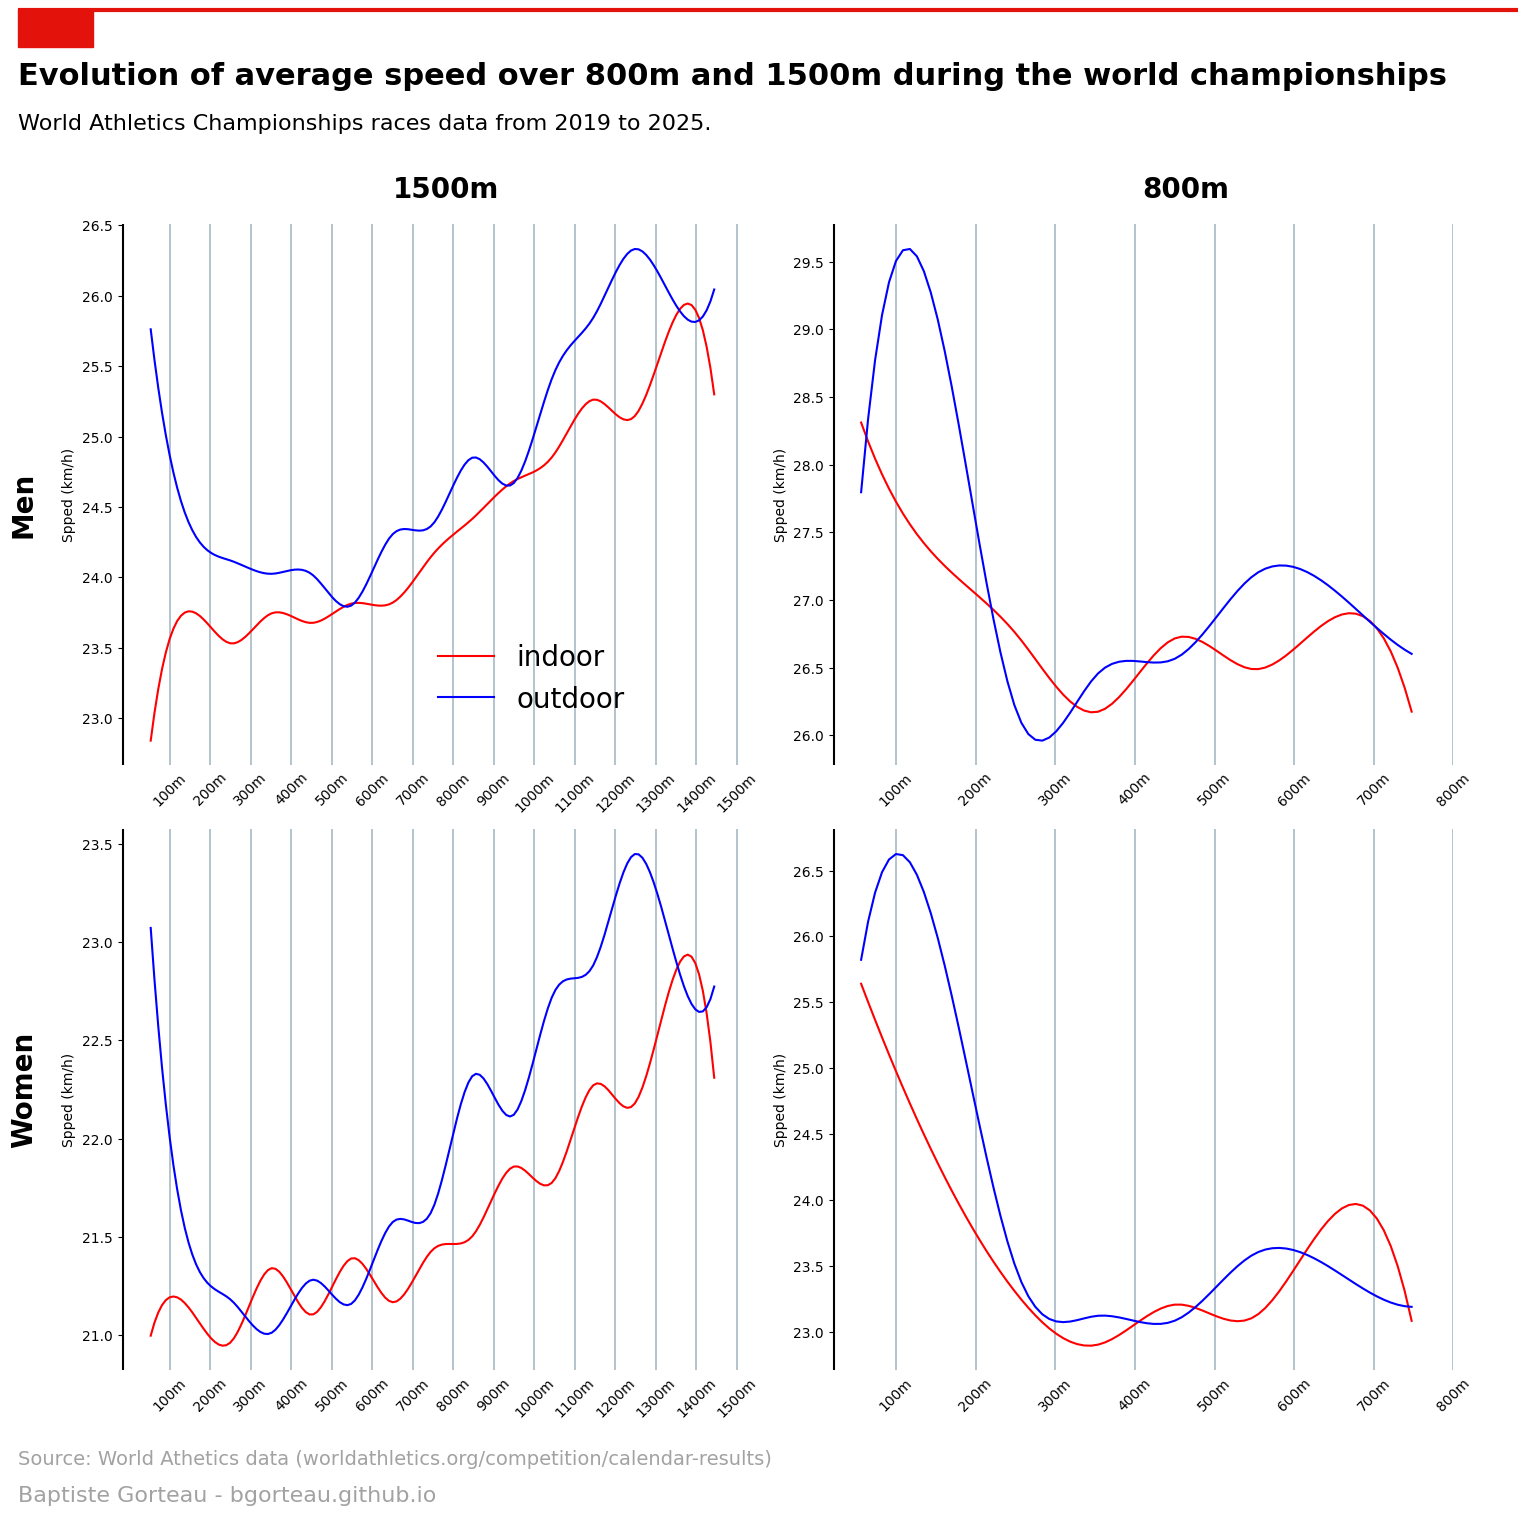

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 7))
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# # Legend

plot_race_speed(axs[0,0], list(data_1500_men_indoor_mean_sd.loc["mean"]),
                list(data_1500_men_outdoor_mean_sd.loc["mean"]), 1500,
                is_legend=True)

plot_race_speed(axs[1,0], list(data_1500_women_indoor_mean_sd.loc["mean"]),
                list(data_1500_women_outdoor_mean_sd.loc["mean"]), 1500)

plot_race_speed(axs[0,1], list(data_800_men_indoor_mean_sd.loc["mean"]),
                list(data_800_men_outdoor_mean_sd.loc["mean"]), 800)

plot_race_speed(axs[1,1], list(data_800_women_indoor_mean_sd.loc["mean"]),
                list(data_800_women_outdoor_mean_sd.loc["mean"]), 800)

# #########################################################

# Add other elements

# plt.legend(loc='lower right', fontsize=15, frameon=False, bbox_to_anchor=(1, -0.25))

# Make room on top and bottom
fig.subplots_adjust(left=0.010, right=1, top=0.5, bottom=0.05)
plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.87])

# Add title
fig.text(
    0, 0.95, "Evolution of average speed over 800m and 1500m during the world championships",
    fontsize=22, fontweight="bold", fontfamily="DejaVu Sans"
)
# Add subtitle
fig.text(
    0, 0.92, "World Athletics Championships races data from 2019 to 2025.",
    fontsize=16, fontfamily="DejaVu Sans"
)

# Add caption
source = "Source: World Athetics data (worldathletics.org/competition/calendar-results)"
fig.text(
    0, 0.03, source, color="#a2a2a2",
    fontsize=14, fontfamily="DejaVu Sans"
)

# Add authorship
fig.text(
    0, 0.005, "Baptiste Gorteau - bgorteau.github.io", color="#a2a2a2",
    fontsize=16, fontfamily="DejaVu Sans"
)

fig.text(-0.005, 0.67, 'Men', va='center', rotation='vertical', fontsize=20, fontweight="bold", fontfamily="DejaVu Sans")
fig.text(-0.005, 0.28, 'Women', va='center', rotation='vertical', fontsize=20, fontweight="bold", fontfamily="DejaVu Sans")

fig.text(0.25, 0.88, '1500m', va='center', fontsize=20, fontweight="bold", fontfamily="DejaVu Sans")
fig.text(0.75, 0.88, '800m', va='center', fontsize=20, fontweight="bold", fontfamily="DejaVu Sans")

# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color="#E3120B", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color="#E3120B"))

# Set facecolor, useful when saving as .png
fig.set_facecolor("white")

plt.show()